In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import beta
import pandas as pd

%matplotlib inline 
mpl.rcParams['figure.figsize'] = (15.0, 9.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

def ind_max(x):
    m = max(x)
    return x.index(m)

/Users/Mine/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module PIL was already imported from /Users/Mine/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/PIL/__init__.pyc, but /Applications/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
'Arms'
'This cell defines the arm class structures used in an MAB algorithm.'
'Bernoulli, Normal and Adversarial arms are included.'

class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
        
class NormalArm():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
  
    def draw(self):
        return random.gauss(self.mu, self.sigma)
    
class AdversarialArm(): #not sure what this is atm
    def __init__(self, t, active_start, active_end):
        self.t = t
        self.active_start = active_start
        self.active_end = active_end

    def draw(self):
        self.t = self.t + 1
        if self.active_start <= self.t <= self.active_end:
            return 1.0
        else:
            return 0.0

In [3]:
'Algorithms'
'Epsilon Greedy, Standard & Annealing'

class EpsilonGreedyStandard():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon #fixed epsilon for standard epsilon greedy alg
        self.counts = counts
        self.values = values # value of theta, cumulated thus far
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        if random.random() > self.epsilon:
            return ind_max(self.values)
        else:
            return random.randrange(len(self.values))
            # this will still return the best arm with 1/n probability, 
            # making epsilon smaller than defined. 
            # It's not a huge empirical problem, but it's rather misleading.
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return
    
class EpsilonGreedyAnnealing():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        t = sum(self.counts) + 1
        epsilon = 1/ math.log(t + 0.0000001)
        
        if random.random() > epsilon:
            return ind_max(self.values)
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [4]:
'Algorithms'
'Softmax'

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
  
    return len(probs) - 1

class Softmax:
    def __init__(self, temperature, counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values
        return
  
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
  
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
    
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [5]:
'Algorithms'
'UCB1'

class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return
  
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
  
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus
        return ind_max(ucb_values)
  
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return


In [6]:
'Algorithms'
'Bayesian with Beta Distribution'

class BayesianBeta():
    def __init__(self, counts, prior): #prior for the Beta distribution is equivalent to values for other algs
        self.counts = counts
        self.prior = prior
        
    def initialize(self, n_arms): #fixed to uniform dist to start, could modify this to take given prior
        self.counts = [0 for col in range(n_arms)]
        self.prior = [[1.0 , 1.0] for col in range(n_arms)]
        return
    
    def select_arm(self, n_arms): 
        sampled_theta = []
        for i in range(n_arms):            
            dist = beta(self.prior[i][0], self.prior[i][1]) #for each arm, construct beta distribution for posterior
            sampled_theta += [dist.rvs()] #draw sample from the beta distributions    
        return sampled_theta.index(np.max(sampled_theta)) #index of the sample with the largest value
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
   
        self.prior[chosen_arm][0] = self.values[chosen_arm][0] + reward
        self.prior[chosen_arm][1] = self.prior[chosen_arm][1] + 1 - reward
        return

In [7]:
'Testing function'
'This cell defines the functions used to test the above algorithms.'
'These are stochastic runs, repeating over a input number of simulations,'
'each with input horizon number of trials.'

def test_algorithm(algo, arms, best_arm, num_sims, horizon): # horizon is length the test is run
    sim_nums           = [0.0 for i in range(num_sims * horizon)] 
    times              = [0.0 for i in range(num_sims * horizon)] 
    chosen_arms        = [0.0 for i in range(num_sims * horizon)]
    rewards            = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    best_arm_boolean   = [0.0 for i in range(num_sims * horizon)]
    # TLDR, can I assign all of them at once?
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            best_arm_boolean[index] = 1 if chosen_arm == best_arm else 0
            # Is this OK TLDR?
            # just trying to create a binary variable with value 0 and 1
            
            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
                
            algo.update(chosen_arm, reward)
        
    d = {'Sim'              : sim_nums, 
         'T'                : times, 
         'ChosenArm'        : chosen_arms, 
         'Reward'           : rewards, 
         'CumulativeReward' : cumulative_rewards, 
         'BestArmBoolean'   : best_arm_boolean}
    return pd.DataFrame(d)

In [8]:
'Visualization functions'
# results - dataframe, groupbycol - non-empty list, title - string

def visualize_avg_reward(resultsDf, groupbycol, title):
    stats = pd.pivot_table(resultsDf, index=['T'], columns=groupbycol, values='Reward', aggfunc = np.mean)
    stats.plot(title=title, ylim=(0,1), yticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel('Time')
    plt.ylabel('Average Reward')
    plt.grid('on')
    
def visualize_cumulative_reward(resultsDf, groupbycol, title):
    stats = pd.pivot_table(resultsDf, index=['T'], columns=groupbycol, values='CumulativeReward', aggfunc = np.mean)
    stats.plot(title=title)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward of Chosen Arm')
    plt.grid('on')

def visualize_prob_best_arm(resultsDf, groupbycol, title):
    stats = pd.pivot_table(resultsDf, index=['T'], columns=groupbycol, values='BestArmBoolean', aggfunc = np.mean)
    stats.plot(title=title, ylim=(0,1), yticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel('Time')
    plt.ylabel('Probability of Selecting the Best Arm')
    plt.grid('on')
    
def visualize_expcted_regret(resultsDf, 

In [194]:
'small bit for testing the arms, do not run'
arms[0].draw()
arms[1].draw()
arms[2].draw()
arms[2].draw()
arms[3].draw()
arms[4].draw()

1.0

In [195]:
'Some common dataframe functions, do not run'
df.describe() #summary
df.head() #same as R head
df.dtype #column type

NameError: name 'df' is not defined

In [205]:
'Simulations'
'Epsilon-Greedy - Standard'

random.seed(1)
thetas = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(thetas)
random.shuffle(thetas)
arms = map(lambda (mu): BernoulliArm(mu), thetas) 
best_arm = ind_max(thetas)
print('Best arm is ' + str(best_arm))

names=['BestArmBoolean', 'ChosenArm', 'CumulativeReward', 'Reward', 'Sim', 'T', 'epsilon']
EpsilonGreedyDf = pd.DataFrame(columns = names)

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedyStandard(epsilon, [], []) 
    algo.initialize(n_arms)
    resultsDf = test_algorithm(algo, arms, best_arm, 5000, 250)
    resultsDf['epsilon'] = epsilon
    EpsilonGreedyDf = pd.concat([EpsilonGreedyDf, resultsDf])
    
EpsilonGreedyDf['Algorithm'] = 'standard eplison-greedy'

Best arm is 1


In [206]:
'Simulations'
'Epsilon-Greedy - Annealing'

algo = EpsilonGreedyAnnealing([], []) 
algo.initialize(n_arms)
resultsDf = test_algorithm(algo, arms, best_arm, 5000, 250)
resultsDf['epsilon'] = 'Annealing'
resultsDf['Algorithm'] = 'annealing eplison-greedy'

EpsilonGreedyDf = pd.concat([EpsilonGreedyDf, resultsDf])

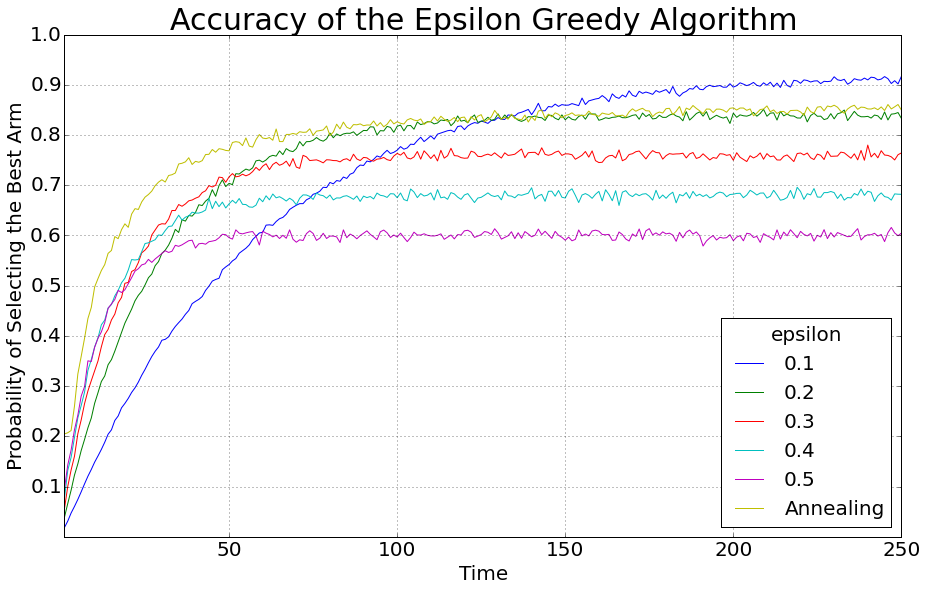

In [208]:
visualize_prob_best_arm(EpsilonGreedyDf, ['epsilon'], 'Accuracy of the Epsilon Greedy Algorithm')

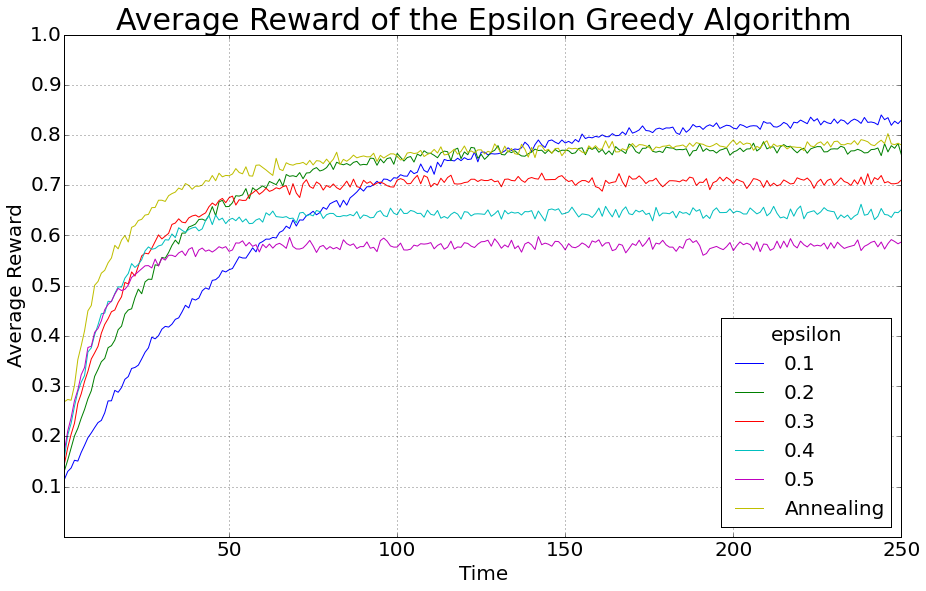

In [210]:
visualize_avg_reward(EpsilonGreedyDf, ['epsilon'], 'Average Reward of the Epsilon Greedy Algorithm')

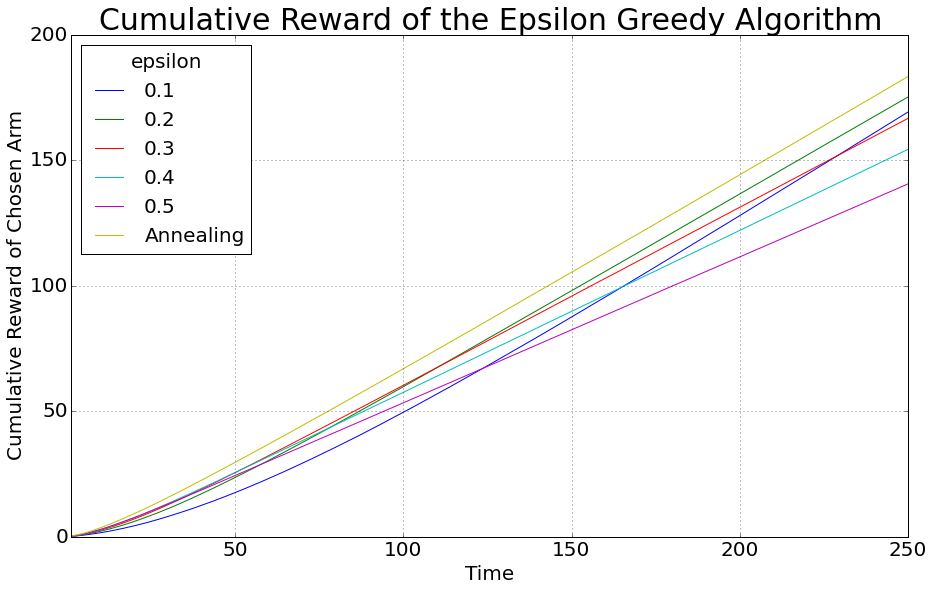

In [209]:
visualize_cumulative_reward(EpsilonGreedyDf, ['epsilon'], 'Cumulative Reward of the Epsilon Greedy Algorithm')

In [12]:
'Simulations'
'Epsilon-Greedy - Standard'
'only 1 simulation'

random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = map(lambda (mu): BernoulliArm(mu), means) 
best_arm = ind_max(means)
print('Best arm is ' + str(best_arm))

names=['BestArmBoolean', 'ChosenArm', 'CumulativeReward', 'Reward', 'Sim', 'T', 'epsilon']
EpsilonGreedyDf2 = pd.DataFrame(columns = names)

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedyStandard(epsilon, [], []) 
    algo.initialize(n_arms)
    resultsDf = test_algorithm(algo, arms, best_arm, 1, 250)
    resultsDf['epsilon'] = epsilon
    EpsilonGreedyDf2 = pd.concat([EpsilonGreedyDf2, resultsDf])
    
EpsilonGreedyDf2['Algorithm'] = 'standard eplison-greedy'

Best arm is 1


In [14]:
'Simulations'
'Epsilon-Greedy - Annealing'
'only 1 simulation'

algo = EpsilonGreedyAnnealing([], []) 
algo.initialize(n_arms)
resultsDf = test_algorithm(algo, arms, best_arm, 1, 250)
resultsDf['epsilon'] = 'Annealing'
resultsDf['Algorithm'] = 'annealing eplison-greedy'

EpsilonGreedyDf2 = pd.concat([EpsilonGreedyDf2, resultsDf])

In [15]:
EpsilonGreedyDf2.describe()

,BestArmBoolean,ChosenArm,CumulativeReward,Reward,Sim,T
count,1500.000000,1500.000000,1500.000000,1500.000000,1500,1500.000000
mean,0.760000,1.237333,87.646000,0.717333,1,125.500000
std,0.427226,0.898264,53.775464,0.450446,0,72.192274
min,0.000000,0.000000,0.000000,0.000000,1,1.000000
25%,1.000000,1.000000,42.000000,0.000000,1,63.000000
50%,1.000000,1.000000,87.000000,1.000000,1,125.500000
75%,1.000000,1.000000,132.000000,1.000000,1,188.000000
max,1.000000,4.000000,207.000000,1.000000,1,250.000000


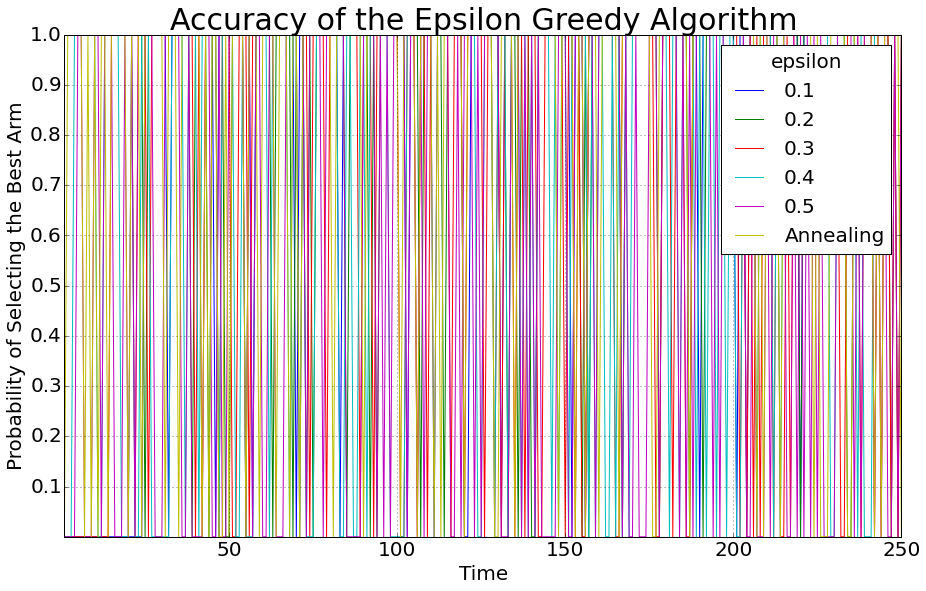

In [16]:
visualize_prob_best_arm(EpsilonGreedyDf2, ['epsilon'], 'Accuracy of the Epsilon Greedy Algorithm')

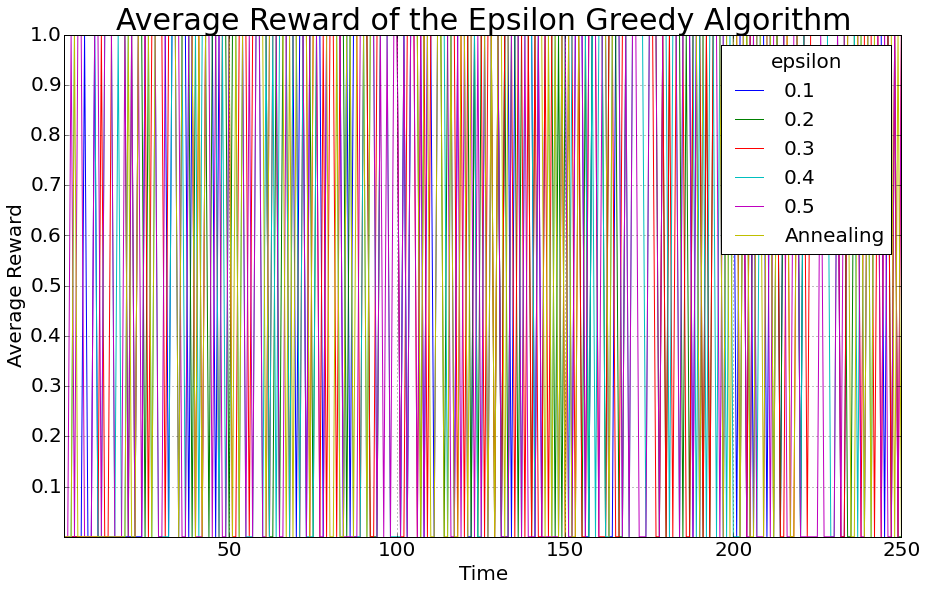

In [17]:
visualize_avg_reward(EpsilonGreedyDf, ['epsilon'], 'Average Reward of the Epsilon Greedy Algorithm')

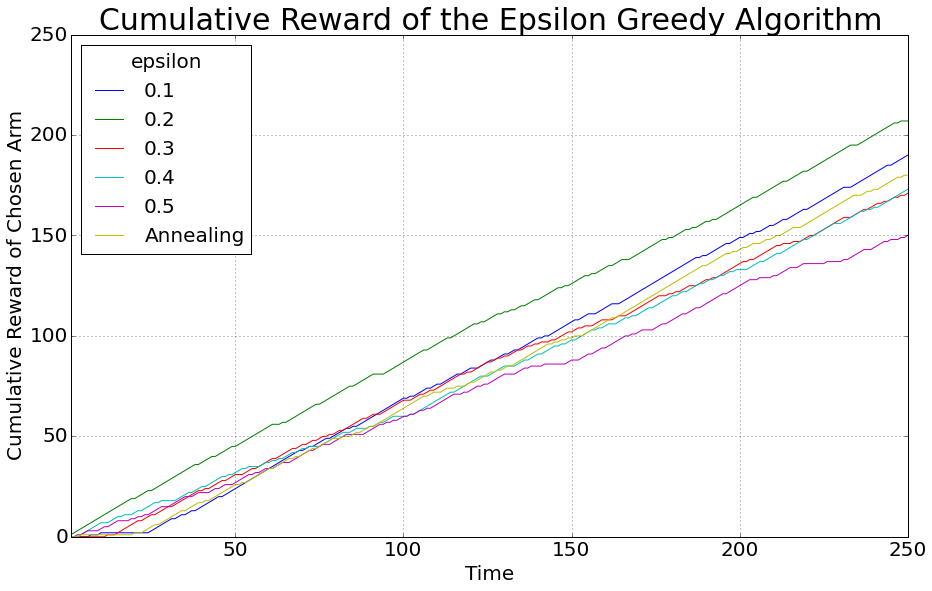

In [18]:
visualize_cumulative_reward(EpsilonGreedyDf, ['epsilon'], 'Cumulative Reward of the Epsilon Greedy Algorithm')